In [3]:
import numpy as np
import cv2
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from skimage.transform import rotate
from sklearn.cluster import KMeans

In [4]:
%matplotlib inline

In [5]:
def gauss1d(sigma, mean,x, order):
    x = np.array(x) - mean
    var = sigma**2
    g = (1/np.sqrt(2*np.pi*var))*(np.exp((-1*x*x)/(2*var)))
    
    if order == 0:
        return g
    elif order == 1:
        g = -g*((x)/(var))
        return g
    else:
        g = g*(((x*x) - var)/(var**2))
        return g

def gauss2d(n,sigma):
    size = int((n-1)/2)
    var = sigma**2
    m = np.asarray([[x**2 + y**2 for x in range(-size,size+1)] for y in range(-size,size+1)])
    output = (1/np.sqrt(2*np.pi*var))*np.exp(-m/(2*var))
    return output

def log2d(n,sigma):
    size = int((n-1)/2)
    var = sigma**2
    m = np.asarray([[x**2 + y**2 for x in range(-size,size+1)] for y in range(-size,size+1)])
    n = (1/np.sqrt(2*np.pi*var))*np.exp(-m/(2*var))
    output = n*(m - var)/(var**2)
    return output

def makefilter(scale, phasex, phasey, pts, sup):
    gx = gauss1d(3*scale, 0,pts[0,...], phasex)
    gy = gauss1d(scale, 0,pts[1,...], phasey)
    image = gx*gy
    image = np.reshape(image,(sup,sup))
    return image
    

In [6]:
def LM_filter_bank():
    sup     = 49
    scalex  = np.sqrt(2) * np.array([1,2,3])
    norient = 6
    nrotinv = 12

    nbar  = len(scalex)*norient
    nedge = len(scalex)*norient
    nf    = nbar+nedge+nrotinv
    F     = np.zeros([sup,sup,nf])
    hsup  = (sup - 1)/2

    x = [np.arange(-hsup,hsup+1)]
    y = [np.arange(-hsup,hsup+1)]

    [x,y] = np.meshgrid(x,y)

    orgpts = [x.flatten(), y.flatten()]
    orgpts = np.array(orgpts)
    
    count = 0
    for scale in range(len(scalex)):
        for orient in range(norient):
#             rotpts = rotate(orgpts,orient)
            angle = (np.pi * orient)/norient
            c = np.cos(angle)
            s = np.sin(angle)
            rotpts = [[c,-s],[s,c]]
            rotpts = np.array(rotpts)
            rotpts = np.dot(rotpts,orgpts)
            F[:,:,count] = makefilter(scalex[scale],0, 1, rotpts, sup)
            F[:,:,count+nedge] = makefilter(scalex[scale],0, 2, rotpts, sup)
            count = count + 1
            
    count = nbar+nedge
    
    scales = np.sqrt(2) * np.array([1,2,3,4])
    
    for i in range(len(scales)):
        F[:,:,count]   = gauss2d(sup, scales[i])
        count = count + 1
        
    for i in range(len(scales)):
        F[:,:,count] = log2d(sup, scales[i])
        count = count + 1
        
    for i in range(len(scales)):
        F[:,:,count] = log2d(sup, 3*scales[i])
        count = count + 1
        
    return F

(49, 49, 48)


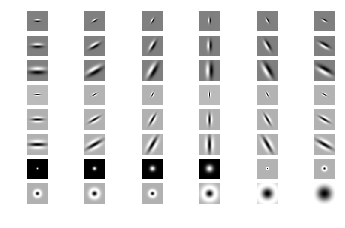

In [7]:
F = LM_filter_bank()
print F.shape
for i in range(0,48):
    plt.subplot(9,6,i+1)
    plt.axis('off')
    plt.imshow(F[:,:,i], cmap = 'gray')



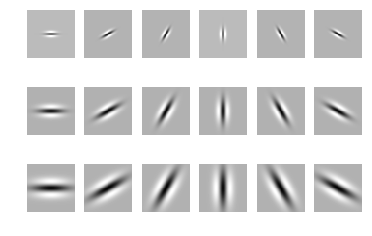

In [6]:
for i in range(0,18):
    plt.subplot(3,6,i+1)
    plt.axis('off')
    plt.imshow(F[:,:,i+18], cmap = 'gray')
    


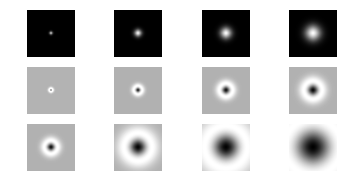

In [7]:
for i in range(0,12):
    plt.subplot(4,4,i+1)
    plt.axis('off')
    plt.imshow(F[:,:,i+36], cmap = 'gray')

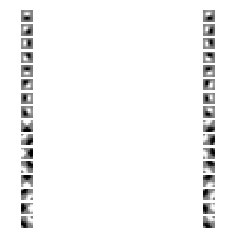

In [8]:
def DOG_filter_bank():
    sobel = np.asarray([[1,2,1],
                        [0,0,0],
                        [-1,-2,-1]])

    ims = []
    s = 2
    o = 16
    sigma = [1,3]
    orientation = []
    for k in range(0,o):
        step_size = 360/o;
        orientation.append(k*step_size)

#     print("Orientations:" + "\n" + str(orientation))

    for i in range(0,s):
        filter_ = convolve2d(gauss2d(5,sigma[i]), sobel)
        for j in range(0,o):
            filt = rotate(filter_,orientation[j])
    #         print(filt)
    #         print("\n")
            ims.append(filt)
            plt.subplot(o,s,o*(i)+j+1)
            plt.axis('off')
            plt.imshow(ims[o*(i)+j],cmap='gray')

    plt.show()
    return ims

ims = DOG_filter_bank()

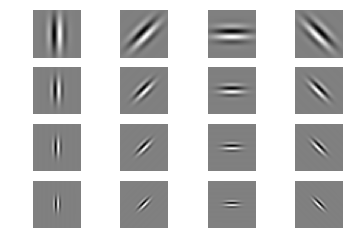

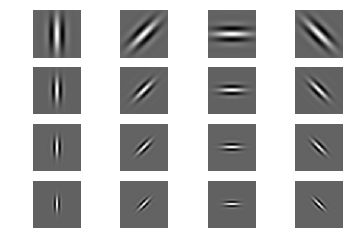

In [9]:
def genGabor(sz, omega, theta, func=np.cos, K=np.pi):
    radius = (int(sz[0]/2.0), int(sz[1]/2.0))
    [x, y] = np.meshgrid(range(-radius[0], radius[0]+1), range(-radius[1], radius[1]+1))

    x1 = x * np.cos(theta) + y * np.sin(theta)
    y1 = -x * np.sin(theta) + y * np.cos(theta)

    gauss = omega**2 / (4*np.pi * K**2) * np.exp(- omega**2 / (8*K**2) * ( 4 * x1**2 + y1**2))
#     myimshow(gauss)
    sinusoid = func(omega * x1) * np.exp(K**2 / 2)
#     myimshow(sinusoid)
    gabor = gauss * sinusoid
    return gabor

g = genGabor((256,256), 0.3, np.pi/4, func=np.cos) 
# change func to "cos", "sin" can generate sin gabor or cos gabor, here we pass a function name as a parameter
# plot(g)
np.mean(g)

theta = np.arange(0, np.pi, np.pi/4) # range of theta
omega = np.arange(0.2, 0.6, 0.1) # range of omega
params = [(t,o) for o in omega for t in theta]
sinFilterBank = []
cosFilterBank = []
gaborParams = []
for (theta, omega) in params:
    gaborParam = {'omega':omega, 'theta':theta, 'sz':(128, 128)}
    sinGabor = genGabor(func=np.sin, **gaborParam)
    cosGabor = genGabor(func=np.cos, **gaborParam)
    sinFilterBank.append(sinGabor)
    cosFilterBank.append(cosGabor)
    gaborParams.append(gaborParam)

plt.figure()
n = len(sinFilterBank)
for i in range(n):
    plt.subplot(4,4,i+1)
    # title(r'$\theta$={theta:.2f}$\omega$={omega}'.format(**gaborParams[i]))
    plt.axis('off'); plt.imshow(sinFilterBank[i],cmap='gray')
plt.show()

plt.figure()
for i in range(n):
    plt.subplot(4,4,i+1)
    # title(r'$\theta$={theta:.2f}$\omega$={omega}'.format(**gaborParams[i]))
    plt.axis('off'); plt.imshow(cosFilterBank[i],cmap='gray')
plt.show()


[  0  90 180 270]
(3, 4)


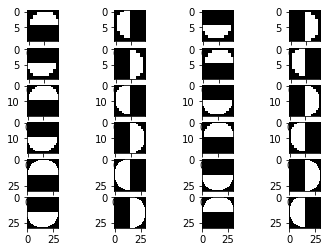

In [10]:
def half_disk(radius):
    hd = np.zeros((radius*2,radius*2))
    rs = radius**2;
    for i in range(0,radius):
        m = (i-radius)**2
        for j in range(0,2*radius):
            if m+(j-radius)**2 < rs:
                hd[i,j] =1
    return hd

orients = np.arange(0,360,360/4)
print(orients)
radii = np.asarray([5,10,15])
mask_l = []
mask_r = []
r = radii.size
o = orients.size
print(r,o)
for i in range(0,radii.size):
    hd = half_disk(radii[i])
    for m in range(0,orients.size):
        mask_1 = rotate(hd,orients[m])
        mask_l.append(mask_1)
        mask_2 = rotate(mask_1,180)
        mask_r.append(mask_2)
        
        plt.subplot(r*2,o,o*2*(i)+m+1)
        plt.imshow(mask_1,cmap='gray')
        plt.subplot(r*2,o,o*2*(i)+m+1+o)
        plt.imshow(mask_2,cmap='gray')
plt.show()


In [11]:
import glob
import os

os.chdir("../BSDS500/Images")
cwd = os.getcwd()
print(cwd)
cv_img = []
for img in sorted(glob.glob("*.jpg")):
    n= cv2.imread(img)
    cv_img.append(n)
os.chdir("../../Code")

/home/abhishek/CMSC733/akathpal_hw0/Phase1/BSDS500/Images


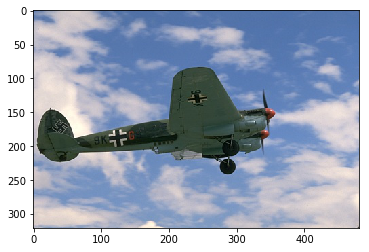

In [12]:
plt.imshow(cv2.cvtColor(cv_img[0],cv2.COLOR_BGR2RGB))

/home/abhishek/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


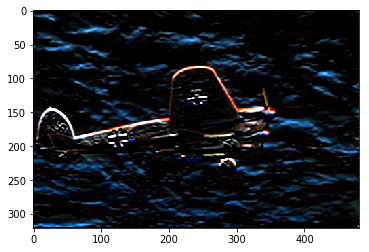

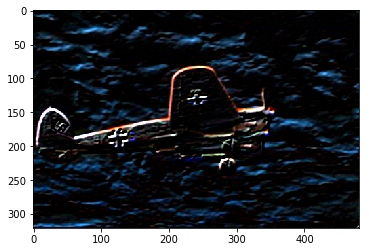

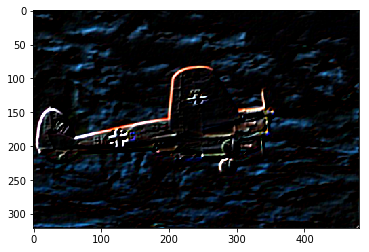

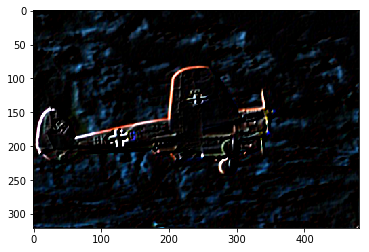

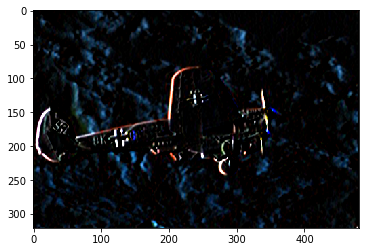

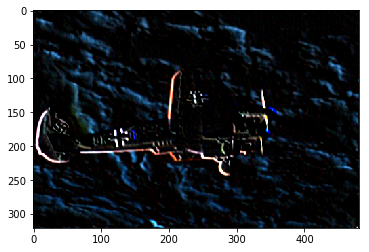

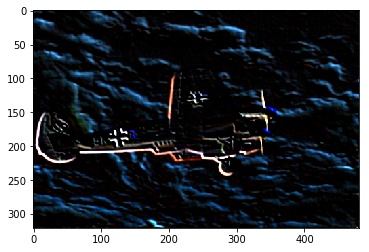

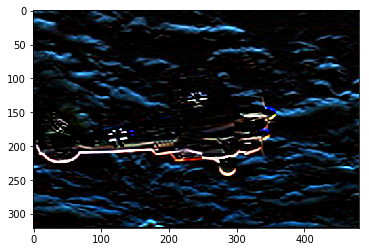

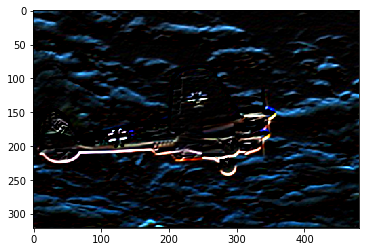

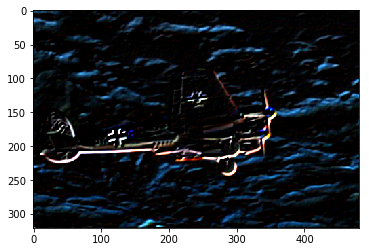

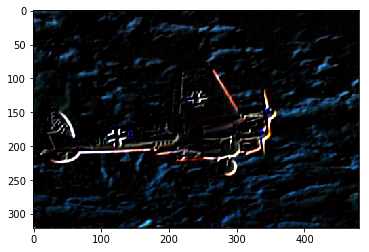

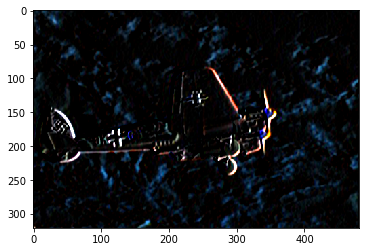

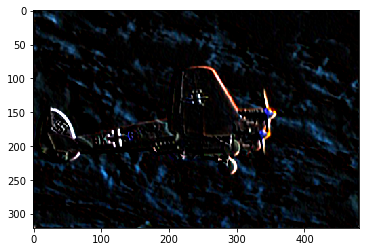

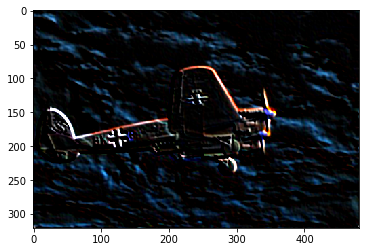

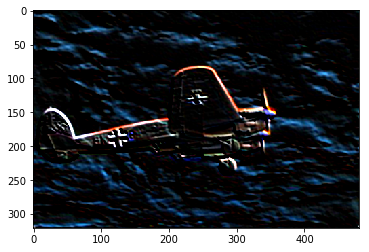

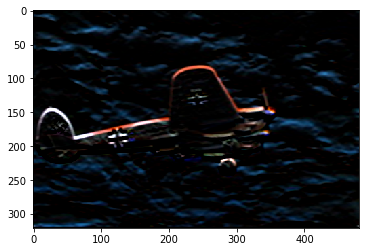

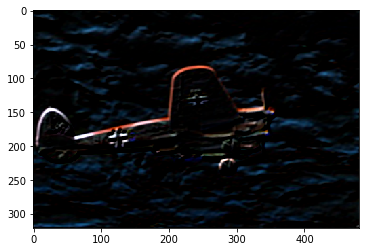

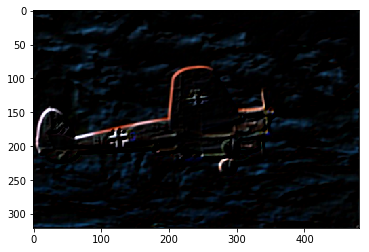

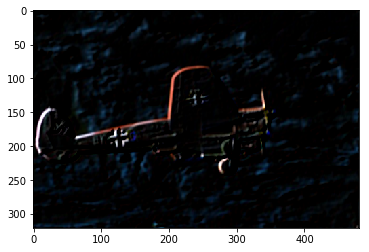

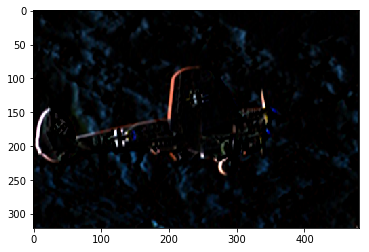

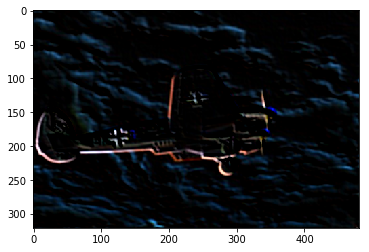

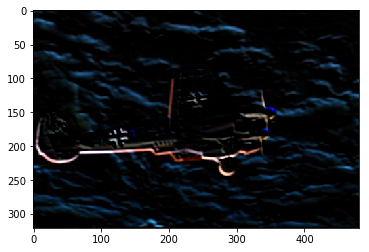

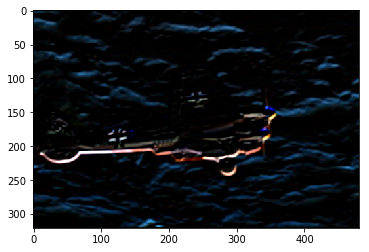

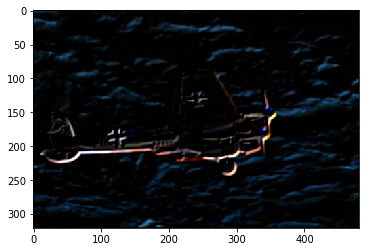

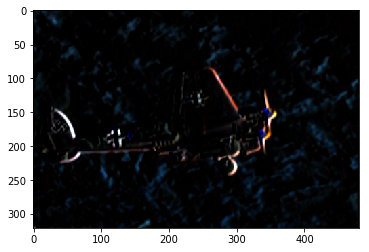

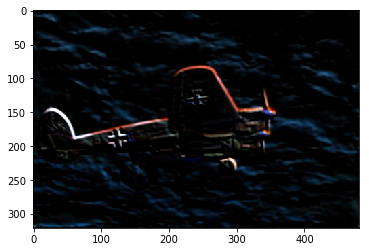

In [13]:
# n = cv2.cvtColor(cv_img[7],cv2.COLOR_BGR2GRAY)
n = cv_img[0]
dst=[]
for i in range(0,len(ims)):
    kernel = ims[i]
    m = cv2.filter2D(n, -1, kernel)
    dst.append(m)
    plt.figure()
    plt.imshow(m,cmap='gray')

In [14]:
filter_bank = []
count = 0
for i in range(0,len(ims)):
    filter_bank.append(ims[i])
    count = count+1

for i in range(0,48):
    filter_bank.append(F[:,:,i])
    count = count+1

for i in range(len(sinFilterBank)):
    filter_bank.append(sinFilterBank[i])
    count = count+1
    
for i in range(len(cosFilterBank)):
    filter_bank.append(cosFilterBank[i])
    count = count+1

print(count,len(filter_bank))

(112, 112)


In [15]:
tmap=cv2.cvtColor(cv_img[0],cv2.COLOR_BGR2GRAY)

print(tmap.size)
print(len(filter_bank))
data = np.zeros((tmap.size,len(filter_bank)))
for i in range(0,len(filter_bank)):
    temp_im = cv2.filter2D(tmap, -1, filter_bank[i])
    temp_im = temp_im.reshape((1,tmap.size))
    data[:,i] = temp_im

k_means = KMeans(n_clusters=64, n_init=4)
k_means.fit(data)
labels = k_means.labels_


154401
112


In [16]:
tmap = np.reshape(labels,(tmap.shape))

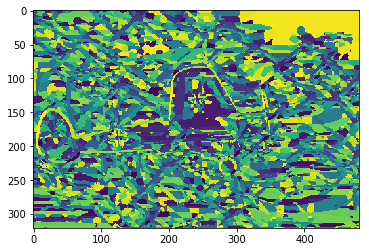

In [17]:
plt.imshow(tmap)

In [18]:
n = cv2.cvtColor(cv_img[0],cv2.COLOR_BGR2GRAY)
m = n.reshape((n.shape[0]*n.shape[1]),1)
k_means = KMeans(n_clusters=16, random_state=4)
k_means.fit(m)
labels = k_means.labels_
print(labels)
bmap = np.reshape(labels,(n.shape[0],n.shape[1]))
print(bmap.shape)
plt.imshow(bmap,cmap='gray')

[ 7  7  7 ...  8  7 15]
(321, 481)


[ 6  6  6 ... 12  7  2]
(321, 481)


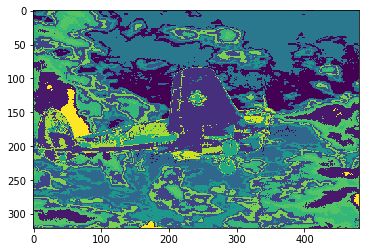

In [19]:
n = cv_img[0]
m = n.reshape((n.shape[0]*n.shape[1]),3)
k_means = KMeans(n_clusters=16, random_state=4)
k_means.fit(m)
labels = k_means.labels_
print(labels)
cmap = np.reshape(labels,(n.shape[0],n.shape[1]))
print(cmap.shape)
plt.imshow(cmap)

In [20]:

def binary(img,bin_value):
    binary_img = img * 0
    for r in range(0,img.shape[0]):
        for c in range(0,img.shape[1]):
            if img[r, c]==bin_value:
                binary_img[r, c] = 1   
            else:
                binary_img[r, c] = 0
#     plt.imshow(binary_img,cmap='gray')
    return binary_img

   
def gradient(maps,numbins,mask_l,mask_r):
    gradient = np.zeros((maps.shape[0],maps.shape[1],12))
    for m in range(0,12):
        chi = np.zeros((maps.shape))
        for i in range(1,numbins):
            tmp = binary(maps,i)
            g = convolve2d(tmp, mask_l[m],'same')
            h = convolve2d(tmp, mask_r[m],'same')
            chi = chi + ((g-h)**2) / (g+h+0.0001)
        gradient[:,:,m] = chi
    return gradient



In [21]:
tg = gradient(tmap,64,mask_l,mask_r)
print(tg.shape)
bg = gradient(bmap,16,mask_l,mask_r)
print(bg.shape)
cg = gradient(cmap,16,mask_l,mask_r)
print(cg.shape)


(321, 481, 12)
(321, 481, 12)
(321, 481, 12)


/home/abhishek/CMSC733/akathpal_hw0/Phase1/BSDS500/CannyBaseline


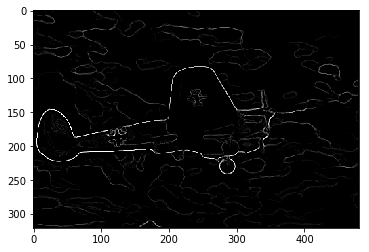

In [24]:
im = "1.png"
# os.chdir("../BSDS500/CannyBaseline")
cwd = os.getcwd()
print(cwd)
c = cv2.imread(im)
plt.imshow(c)


In [25]:
os.chdir("../SobelBaseline")
s = cv2.imread(im)
plt.imshow(s)

(321, 481)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.01479005 0.01456709 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.02954595]
 [0.06165833 0.         0.         ... 0.         0.05820412 0.11533532]
 [0.         0.05465764 0.         ... 0.         0.10625608 0.        ]]


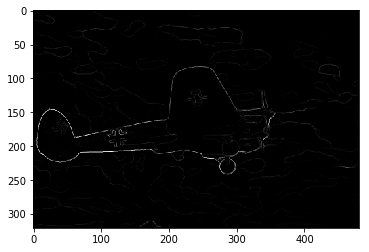

In [47]:
sm = cv2.cvtColor(s,cv2.COLOR_BGR2GRAY)
cm = cv2.cvtColor(c,cv2.COLOR_BGR2GRAY)

tgm = np.mean(tg, axis=2);
print(tgm.shape)
bgm = np.mean(bg, axis=2);
cgm = np.mean(cg, axis=2);
w = 0.5
pb = ((tgm+bgm+cgm)/3)*(w*cm+(1-w)*sm)
plt.imshow(pb,cmap='gray')
low = np.min(pb.flatten())
high = np.max(pb.flatten())
pbm =(pb-low)/(high-low)
plt.imsave("1_pb.png",pbm,cmap='gray')
print(pbm)

In [ ]:
# low=min(pb(:));
# high=max(pb(:));
# pb=(pb-low)/(high-low);